# **Importing dataset and relevant libraries**

In [1]:
import numpy as np
import pandas as pd
import spacy
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from time import time as tt

!pip install clean-text
!python -m spacy download en_core_web_md

from cleantext import clean

USING_COLAB = True
if USING_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/MSc Big Data and Business Intelligence/Applied Machine Learning/Applied Machine Learning Coursework/comp1804_coursework_dataset_23-24.csv')

X = data[['paragraph', 'has_entity']]
y = data[['category']]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.5 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171034 sha256=1970b4a63c9753d10e1f46c3d401b016667dbc007f9c9b39e1900bbf781ad5fe
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 18.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Mounted at /content/drive


# **Data cleaning**

In [2]:
duplicates_rows = X.duplicated()
print(f'There are {duplicates_rows.sum()} duplicates rows.')

X = X[~duplicates_rows]
y = y[~duplicates_rows]

print((X["has_entity"] == 'data missing').sum())

imptr = SimpleImputer(missing_values= 'data missing', strategy='most_frequent')
imptr = imptr.fit(X[['has_entity']])

X[['has_entity']] = imptr.transform(
    X[['has_entity']])

imptr_example = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
imptr_example = imptr_example.fit(y[['category']])
y[['category']] = imptr_example.transform(
    y[['category']])

print(y['category'].isna().sum())

There are 350 duplicates rows.
24
0


In [3]:
y.loc[y.category=='Artificial intelligence','category'] = 'artificial intelligence'
y.loc[y.category=='Biographies','category'] = 'biographies'
y.loc[y.category=='Philosophy','category'] = 'philosophy'
y.loc[y.category=='Programming','category'] = 'programming'
y.loc[y.category=='Movies about artificial intelligence','category'] = 'movies about artificial intelligence'

In [4]:
def clean_text(x):
  return clean(x,
    fix_unicode=True,
    lower=True,
    no_line_breaks=True,
    no_punct=False,
    no_urls=True,
    replace_with_url="",
    no_emails=True,
    replace_with_email="",
    no_phone_numbers=True,
    replace_with_phone_number="",
    lang="en"
    )

X['clean_text']= X['paragraph'].apply(clean_text)

In [5]:
X['text_length'] = X['clean_text'].apply(len)

# **Embedding**

In [6]:
import string
EXTRA_PUNCT = string.punctuation

nlp = spacy.load('en_core_web_md')

def get_spacy_doc_embedding(clean_text):
   doc_ = nlp(clean_text)
   return doc_.vector

t0 = tt()
X_emb = X['clean_text'].apply(lambda x:  pd.Series(get_spacy_doc_embedding(x)))
new_data = X_emb.join(X[['text_length', 'has_entity']])
new_data.columns = new_data.columns.astype(str)
print(f'Time elapsed is {(tt()-t0):.2f} seconds')

Time elapsed is 293.42 seconds


# **Data Encoding**

In [7]:
ct = ColumnTransformer(
    [
        (
            'onehot_categorical',
            OneHotEncoder(),
            ['has_entity']
        ),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

encoded_array= ct.fit_transform(new_data)
encoded_col_names= ct.get_feature_names_out()
print(encoded_col_names)

new_data = pd.DataFrame(encoded_array, columns=encoded_col_names)

['has_entity_ORG_NO_PRODUCT_NO_PERSON_NO_'
 'has_entity_ORG_NO_PRODUCT_NO_PERSON_YES_'
 'has_entity_ORG_NO_PRODUCT_YES_PERSON_NO_'
 'has_entity_ORG_NO_PRODUCT_YES_PERSON_YES_'
 'has_entity_ORG_YES_PRODUCT_NO_PERSON_NO_'
 'has_entity_ORG_YES_PRODUCT_NO_PERSON_YES_'
 'has_entity_ORG_YES_PRODUCT_YES_PERSON_NO_'
 'has_entity_ORG_YES_PRODUCT_YES_PERSON_YES_' '0' '1' '2' '3' '4' '5' '6'
 '7' '8' '9' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '21'
 '22' '23' '24' '25' '26' '27' '28' '29' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49'
 '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '60' '61' '62' '63'
 '64' '65' '66' '67' '68' '69' '70' '71' '72' '73' '74' '75' '76' '77'
 '78' '79' '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '90' '91'
 '92' '93' '94' '95' '96' '97' '98' '99' '100' '101' '102' '103' '104'
 '105' '106' '107' '108' '109' '110' '111' '112' '113' '114' '115' '116'
 '117' '118' '119' '120' '121' '122' '123' '

In [8]:
lblEncoder_Y = LabelEncoder()
lblEncoder_y = lblEncoder_Y.fit(y['category'])
y['category'] = lblEncoder_y.transform(y['category'])

# **Normalisation**

In [9]:
ct = ColumnTransformer(
   transformers= [
       (
           "scaling",
           StandardScaler(),
           ['text_length'],
       )
   ],
   remainder="passthrough",
   verbose_feature_names_out=False
)

# **Oversampling**

In [10]:
new_data, y = SMOTE().fit_resample(new_data, y)

# **Data Splitting**

In [11]:
train_X, test_X, train_y, test_y = train_test_split(new_data, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

# **Pipeline Creation & Hyperparameter Tuning**

In [16]:
clf_ = Pipeline(
         steps =[('scaling', ct),
               ('clf', MLPClassifier()),
       ]
     )

hparameters = {'clf__hidden_layer_sizes': ((30,40)),
               'clf__alpha': (0.0001, 0.0005),
              }

clf_search = GridSearchCV(clf_, hparameters, scoring= "accuracy", cv= 5)

# **GridSearch Training & Results**

In [17]:
t0 = tt()
_ =clf_search.fit(train_X, train_y)
print(f'Time taken to train gridsearch: {tt()-t0:.2f} seconds.')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conver

Time taken to train gridsearch: 702.28 seconds.


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
cv_res = pd.DataFrame(clf_search.cv_results_)

# **Evaluation**

                                      precision    recall  f1-score   support

             artificial intelligence       0.92      0.87      0.90       581
                         biographies       0.80      0.94      0.87       580
movies about artificial intelligence       1.00      1.00      1.00       581
                          philosophy       0.91      0.81      0.86       581
                         programming       0.94      0.95      0.95       581

                            accuracy                           0.91      2904
                           macro avg       0.92      0.91      0.91      2904
                        weighted avg       0.92      0.91      0.91      2904



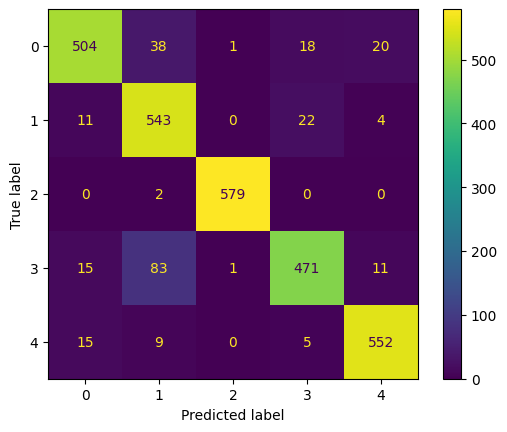

In [15]:
best_clf = clf_search.best_estimator_
y_pred = best_clf.predict(test_X)
class_names = ['artificial intelligence', 'biographies', 'movies about artificial intelligence', 'philosophy', 'programming']
print(classification_report(test_y, y_pred, target_names = class_names))

cm= ConfusionMatrixDisplay.from_estimator(best_clf, test_X, test_y)